In [1]:
import os
import plotly
import numpy as np 
import pandas as pd
import tensorflow as tf 
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from tensorflow.keras import layers
from plotly.subplots import make_subplots
from keras.layers import Dense, Dropout, Flatten
from sklearn.metrics import classification_report
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
class_names = pd.read_csv( r'./CLASS NAMES.csv')["COMMON NAME"].tolist()

In [3]:
working_directory = r'./'
train_path = os.path.join(working_directory, 'train')
test_path = os.path.join(working_directory, 'test')
valid_path = os.path.join(working_directory, 'valid')

In [4]:
train_generator = ImageDataGenerator(rescale = 1./255.)

test_generator = ImageDataGenerator( rescale = 1./255. )

valid_generator = ImageDataGenerator( rescale = 1./255. )

In [5]:
train = train_generator.flow_from_directory(train_path, batch_size = 20, class_mode = 'categorical', classes=class_names, target_size = (224, 224))

valid = valid_generator.flow_from_directory( valid_path,  batch_size = 20, class_mode = 'categorical',classes=class_names, target_size = (224, 224))

test = test_generator.flow_from_directory(test_path, batch_size = 20, class_mode = 'categorical',classes=class_names, target_size = (224, 224))

Found 9285 images belonging to 75 classes.
Found 375 images belonging to 75 classes.
Found 375 images belonging to 75 classes.



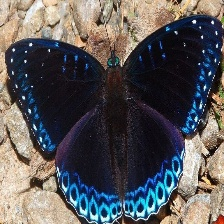
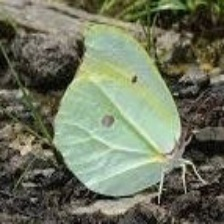
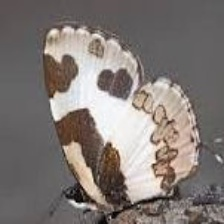
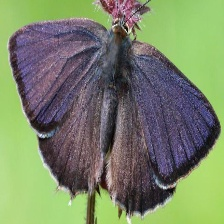
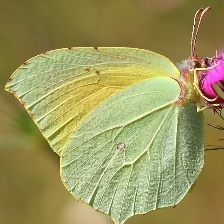
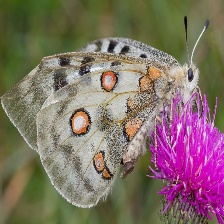
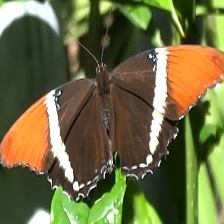
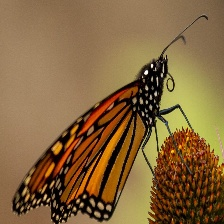
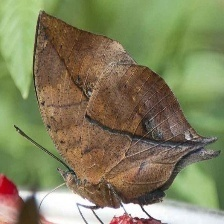
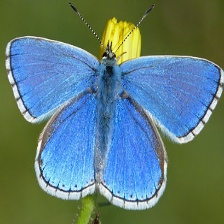
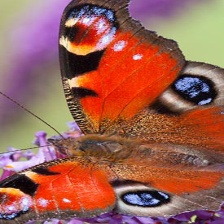
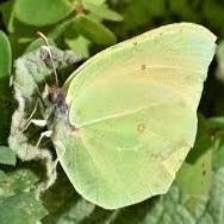
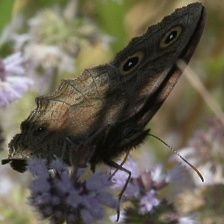
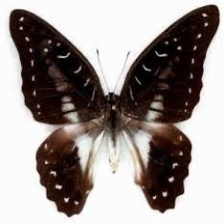
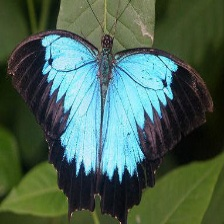
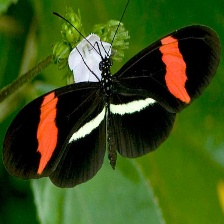

In [6]:
img, label = train.next()
rows,cols = 4,4
fig = make_subplots(rows=rows, cols=cols,horizontal_spacing=0.05,subplot_titles=[class_names[np.argmax(label[i])] for i in range(rows*cols)])
indx=0
for i in range(rows):
    for j in range(cols):
        fig.add_trace(px.imshow(img[indx]).data[0],i+1,j+1)
        indx+=1
        fig.update_layout(width=1000,height=1000)
        fig.update_xaxes(showticklabels=False)
        fig.update_yaxes(showticklabels=False)
fig.show()


In [7]:
base_model = VGG16(input_shape = (224, 224, 3), include_top = False, weights = 'imagenet')

In [8]:
for layer in base_model.layers:
    layer.trainable = False

In [9]:
x = layers.Flatten()(base_model.output)
x = layers.Dense(4096, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(4096, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(75, activation='softmax')(x)

model = tf.keras.models.Model(base_model.input, x)

model.compile(optimizer = tf.keras.optimizers.Adam(0.0001), loss = 'categorical_crossentropy',metrics = ['acc'])

In [10]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [11]:
callback = EarlyStopping(monitor='val_loss', patience=5)
checkpoint = ModelCheckpoint('butterfly-Image_model_weights.hdf5', monitor='val_loss', verbose=2, save_best_only=True, mode='min')
history = model.fit(train, validation_data = valid,epochs = 50, batch_size=32, callbacks=[callback, checkpoint])

Epoch 1/50
465/465 [==============================] - ETA: 0s - loss: 3.3859 - acc: 0.2144
Epoch 1: val_loss improved from inf to 1.49859, saving model to butterfly-Image_model_weights.hdf5
465/465 [==============================] - 2235s 5s/step - loss: 3.3859 - acc: 0.2144 - val_loss: 1.4986 - val_acc: 0.6293
Epoch 2/50
465/465 [==============================] - ETA: 0s - loss: 1.4699 - acc: 0.5976
Epoch 2: val_loss improved from 1.49859 to 0.74545, saving model to butterfly-Image_model_weights.hdf5
465/465 [==============================] - 2352s 5s/step - loss: 1.4699 - acc: 0.5976 - val_loss: 0.7455 - val_acc: 0.7893
Epoch 3/50
465/465 [==============================] - ETA: 0s - loss: 0.8781 - acc: 0.7491
Epoch 3: val_loss improved from 0.74545 to 0.53742, saving model to butterfly-Image_model_weights.hdf5
465/465 [==============================] - 2284s 5s/step - loss: 0.8781 - acc: 0.7491 - val_loss: 0.5374 - val_acc: 0.8347
Epoch 4/50
465/465 [==============================] -

In [16]:
fig = make_subplots(rows=1, cols=2,subplot_titles=("Loss", "Accuracy"))
fig.add_trace(go.Scatter(y=history.history['loss'], mode='lines', name='Train Loss'),1,1)
fig.add_trace(go.Scatter(y=history.history['val_loss'], mode='lines', name='Validation Loss'),1,1)
fig.add_trace(go.Scatter(y=history.history['acc'], mode='lines', name='Train Accuracy'),1,2)
fig.add_trace(go.Scatter(y=history.history['val_acc'],mode='lines', name='Validation Accuracy'),1,2)
fig.update_xaxes(title_text="Epoch", row=1, col=1)
fig.update_xaxes(title_text="Epoch", row=1, col=2)
fig.show()

In [17]:
model.load_weights('butterfly-Image_model_weights.hdf5')

In [18]:
print(classification_report(test.classes[test.index_array],  model.predict(test).argmax(axis=1), target_names=class_names))


19/19 [==============================] - 69s 4s/step
                           precision    recall  f1-score   support

                   ADONIS       1.00      1.00      1.00         5
AFRICAN GIANT SWALLOWTAIL       1.00      1.00      1.00         5
           AMERICAN SNOOT       1.00      0.60      0.75         5
                    AN 88       1.00      1.00      1.00         5
                  APPOLLO       0.80      0.80      0.80         5
                    ATALA       0.83      1.00      0.91         5
 BANDED ORANGE HELICONIAN       1.00      1.00      1.00         5
           BANDED PEACOCK       0.71      1.00      0.83         5
            BECKERS WHITE       0.83      1.00      0.91         5
         BLACK HAIRSTREAK       1.00      1.00      1.00         5
              BLUE MORPHO       0.83      1.00      0.91         5
        BLUE SPOTTED CROW       1.00      1.00      1.00         5
           BROWN SIPROETA       0.80      0.80      0.80         5
        